# MACD策略

In [1]:
# 获取股票数据
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [322]:
tickers = ['AAPL','BABA','BIDU','GOOGL','META','AMZN']
data = yf.download(tickers = tickers, start = '2022-01-01', end='2022-12-31')
# data

[                       0%%                      ]

[*********************100%%**********************]  6 of 6 completed


In [323]:
data.to_csv('./dataset/2022_macd.csv')

In [2]:
# 计算df的短期平均ma1， 长期平均ma2
def macd(df):
    # 计算ma1和ma2
    df['ma1'] = df['Close'].rolling(window=ma1, min_periods=1).mean() # 快线
    df['ma2'] = df['Close'].rolling(window=ma2, min_periods=1).mean() # 慢线
    # 短期均线与长期均线的DIF
    df['diff'] = df['ma1'] - df['ma2']
    # DEA = DIFF的平滑（9天的均值）
    df['dea'] = df['diff'].rolling(window=9, min_periods=1).mean() # 两次平滑 => 过滤异常值，效果好
    return df

In [3]:
def signal_compute(df):
    '''
    当短均线大于长均线时，我们看多并持有
    当短均线小于长均线时，我们清仓
    背后的逻辑是短均线有动量的影响（惯性）
    我们可以用diff = 长均线-短均线
    diff有时候是正，有时是负
    这就是为什么称为Moving Average Convergence Divergence
    '''
    # 计算短期平均ma1, 长期平均ma2， diff， dea
    df = macd(df)
    # 初始化positions均为0
    df['positions'] = 0

    # 当短均线 > 长均线, positions=1
    '''
    df['ma1'] 快线特征， [ma1:] 12之后的数据
    '''
    df['positions'][ma1:] = np.where(df['ma1'][ma1:] >= df['ma2'][ma1:],1,0)
    # df['positions'] = np.where(df['diff']>df['dea'],1,0)
    
    # positions表明了需要持有，计算前后两天的positions diff, 代表交易信号signals
    # signals=1 买入，signals=-1 卖出
    df['signals'] = df['positions'].diff()

    # 震荡diff = 两个移动平均之差
    df['diff'] = df['ma1'] - df['ma2']
    df['macd'] = 2 * (df['diff'] - df['dea'])

    return df

In [4]:
# 绘制回测结果
def plot(df, ticker):
    # the first plot is the actual close price with long/short positions
    # 绘制实际的股票收盘数据
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(df.index, df['Close'], label=ticker)
    # 只显示时刻点，不显示折线图 => 设置linewidth=0
    ax.plot(df.loc[df['signals']==1].index, df['Close'][df['signals']==1], label='Buy', linewidth=0, marker='^', c='g')
    ax.plot(df.loc[df['signals']==-1].index, df['Close'][df['signals']==-1], label='Sell', linewidth=0, marker='v', c='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    plt.show()

    # 显示diff，即ma1-ma2
    fig = plt.figure(figsize=(12, 6))
    cx = fig.add_subplot(211)
    df['diff'].plot(kind='bar', color='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks([]) # 不显示x轴刻度
    # plt.xlabel('')
    # plt.title('MACD Diff (ma1-ma2)')
    # plt.title('MACD 2*(diff-dea)')

    # 绘制ma1, ma2曲线
    bx = fig.add_subplot(212)
    bx.plot(df.index, df['ma1'], label='ma1', color='orange')
    bx.plot(df.index, df['ma2'], label='ma2', linestyle=':', color='blue')

    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [35]:
# MACD简单有效，但是需要注意，进入信号总是很晚，需要注意向下的均线
# 可以采用12， 26， 也可以采用10和21
ma1 = 12
ma2 = 26

# 使用slicer进行切片，如果数据很大，回测曲线会比较乱，因为有太多的标记记载一起
slicer = 0

# 获取某一支股票的数据
data = yf.download(tickers='AAPL', start='2021-01-01', end='2022-1-1')
data.to_csv('./dataset/AAPL_2021_MACD.csv')
# data

[*********************100%%**********************]  1 of 1 completed


In [36]:
# pd.set_option('display.max_rows', None)
# 计算ma1，ma2， positions， signals， diff指标
df = signal_compute(data)
df['Date'] = pd.to_datetime(df.index)
df['name'] = 'AAPL'
# df.head()


/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_71759/3019463298.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['positions'][ma1:] = np.where(df['ma1'][ma1:] >= df['ma2'][ma1:],1,0)


In [37]:
print('买入信号：', df.loc[df['signals']==1].index)
print('买入信号时的收盘价：',df['Close'][df['signals']==1])
print('卖出信号：', df.loc[df['signals']==-1].index)
print('卖出信号时的收盘价：', df['Close'][df['signals']==-1])

买入信号： DatetimeIndex(['2021-01-21', '2021-04-07', '2021-06-15', '2021-10-21'], dtype='datetime64[ns]', name='Date', freq=None)
买入信号时的收盘价： Date
2021-01-21    136.869995
2021-04-07    127.900002
2021-06-15    129.639999
2021-10-21    149.479996
Name: Close, dtype: float64
卖出信号： DatetimeIndex(['2021-02-19', '2021-05-10', '2021-09-21'], dtype='datetime64[ns]', name='Date', freq=None)
卖出信号时的收盘价： Date
2021-02-19    129.869995
2021-05-10    126.849998
2021-09-21    143.429993
Name: Close, dtype: float64


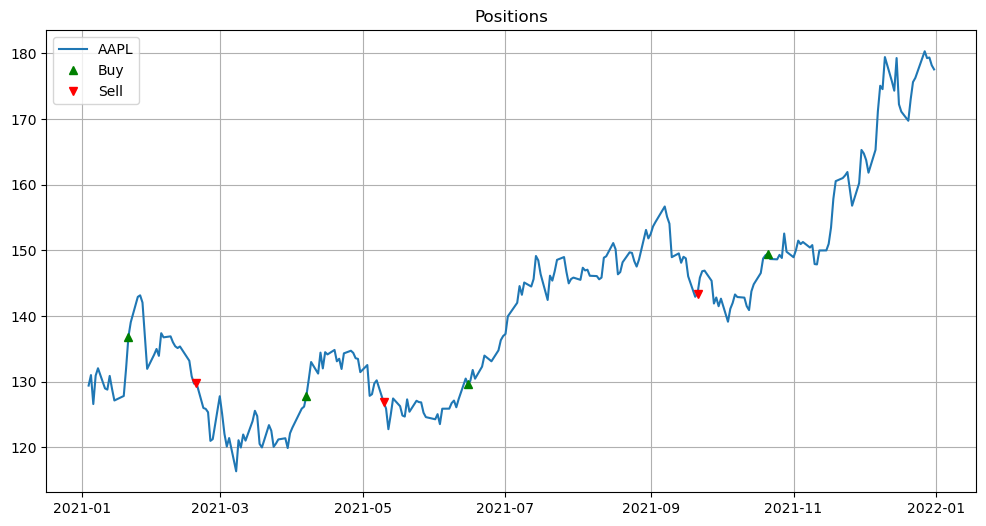

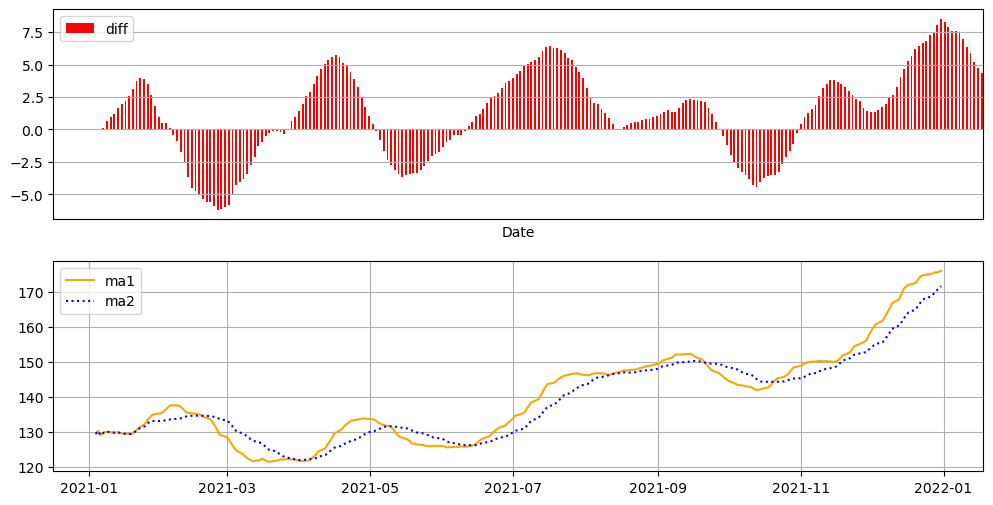

In [38]:
plot(df, 'AAPL')

In [9]:
# 信号分布
df['signals'].value_counts()

signals
 0.0    244
 1.0      4
-1.0      3
Name: count, dtype: int64

In [10]:
df['positions'].value_counts()

positions
1    161
0     91
Name: count, dtype: int64

In [ ]:
# 交易日情况
open_dates = np.unique(df.Date)
print(len(open_dates))
open_dates

In [11]:
# 计算投资组合价值
def get_portfolio_value(port, evaluation_date):
    # if evaluation_date not in open_dates:
    #     print('Market closed for today')
    #     return 0
    # 总价值
    total_value = 0
    # 累加每支股票的value
    for stock in port.keys():
        if stock == 'cash':
            total_value += port['cash']
            continue
        # 找到evaluation_date时，该股票的price
        print(stock)
        stock_price = df.iloc[0]['Close']
        # 计算该股票的value
        position = stock_price * port[stock]
        total_value += position
    # 打印当前的portfolio
    # print(port)  
    return total_value

In [12]:
def portfolio_buy(port, purchase_day, stock_name, num):
    # 如果不开市
    # if purchase_day not in open_dates:
    #     print('Market closed for today')
    #     return port
    # 计算股票需要购买的金额
    stock_price = df[(df.name==stock_name) & (df.Date==purchase_day)].iloc[0]['Open']
    order_price = stock_price * num
    # 考虑portfolio钱够不够的问题
    if port['cash'] < order_price:
        # 没买成，原封不动
        return port
    # 购买成公，cash减少
    port['cash'] -= order_price
    # 如果之前没有持有过这个股票
    if stock_name not in port.keys():
        port[stock_name] = num
        return port
    elif stock_name in port.keys():
        port[stock_name] += num
        return port
    else:
        print('Error')
        return port

In [13]:
def portfolio_sell(port, sell_day, stock_name, num):
    # 如果不开市
    # if sell_day not in open_dates:
    #     print('Market closed for today')
    #     return port
    # 计算卖出的股票金额
    stock_price = df[(df.name==stock_name) & (df.Date==sell_day)].iloc[0]['Close']
    order_price=stock_price * num
    # 如果之前没有持有过这个股票
    if stock_name not in port.keys():
        # 没卖成，原封不动
        return port
    # 如果卖出的数量 > 手上持有的数量，没卖成
    if num > port[stock_name]:
        return port
    # 卖成功了，减少股票数量，增加cash
    if stock_name in port.keys():
        port[stock_name] -= num
        port['cash'] += order_price
        return port

In [28]:
# 假设初始资金10000
portfolio = dict()
portfolio['cash'] = 10000

In [15]:
# 计算能买多少股
valid_num = int(portfolio['cash'] / df.iloc[0]['Open'])
valid_num

74

In [25]:
# 买卖股票
portfolio_buy(portfolio, '2021-01-21', 'AAPL', 70)
portfolio_sell(portfolio, '2021-02-19', 'AAPL', 70)
portfolio_buy(portfolio, '2021-04-07', 'AAPL', 70)
portfolio_sell(portfolio, '2021-05-10', 'AAPL', 70)
portfolio_buy(portfolio, '2021-06-15', 'AAPL', 70)
portfolio_sell(portfolio, '2021-09-21', 'AAPL', 70)
portfolio_buy(portfolio, '2021-10-21', 'AAPL', 70)
portfolio_sell(portfolio, '2021-12-30', 'AAPL', 70)

{'cash': 12797.898483276367, 'AAPL': 0}

In [30]:
portfolio_buy(portfolio, '2021-01-21', 'AAPL', 70)
portfolio_sell(portfolio, '2021-12-30', 'AAPL', 70)

{'cash': 13107.999572753906, 'AAPL': 0}